In [139]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import data_loader

In [140]:
#Загрузка данных, используя созданный ранее data_loader
filepath = 'pocemon.csv'
df = data_loader.load_data(filepath)

In [141]:
# выводим первые 5 строк из датасета для того, чтобы ознакомиться с ними и с данными
df.head(5)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45.0,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60.0,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80.0,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80.0,1,False
4,6,Charizard,Fire,Flying,78,84,78,109,85,100.0,1,False


In [142]:
# Вывод названий колонок
df.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

In [143]:
# Определение числовых и категориальных признаков
numeric_features = ['#','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation']
categorical_features = ['Name','Type 1','Type 2','Legendary']

In [144]:
# Информация про значения в датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   #           414 non-null    int64  
 1   Name        414 non-null    object 
 2   Type 1      414 non-null    object 
 3   Type 2      414 non-null    object 
 4   HP          414 non-null    int64  
 5   Attack      414 non-null    int64  
 6   Defense     414 non-null    int64  
 7   Sp. Atk     414 non-null    int64  
 8   Sp. Def     414 non-null    int64  
 9   Speed       389 non-null    float64
 10  Generation  414 non-null    int64  
 11  Legendary   414 non-null    bool   
dtypes: bool(1), float64(1), int64(7), object(3)
memory usage: 36.1+ KB


In [145]:
# Вывод статистической информации по числовым признакам из датасета
df.describe()

# Мы видим, что в колонке Speed у  нас есть пропущенные значения (общее количество значений 389, а не 414)

,#,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,389.000000,414.000000
mean,376.565217,70.649758,83.173913,79.676329,77.048309,75.565217,70.760925,3.410628
std,212.840297,22.896557,33.698473,32.593788,33.805061,27.949961,28.630276,1.663010
min,1.000000,1.000000,10.000000,15.000000,10.000000,20.000000,10.000000,1.000000
25%,205.500000,55.000000,59.250000,55.000000,50.000000,55.000000,50.000000,2.000000
50%,378.000000,70.000000,80.000000,75.500000,70.000000,75.000000,70.000000,3.000000
75%,560.750000,85.000000,103.000000,100.000000,100.000000,94.750000,92.000000,5.000000
max,721.000000,150.000000,190.000000,230.000000,180.000000,230.000000,160.000000,6.000000


In [146]:
# Вывод статистической информации по категориальным признакам из датасета
categorical_stats = df.describe(include=['O'])
print(categorical_stats)

# Вывод: Во всех колонках у нас по 414 не нулевых значений. Уникальный 414 в первой и по 18 во второй и третьей (характеризующей типы покемонов). 
# Чаще всего повторяются типы Водный (53 раза) и Летающий (97 раз)

             Name Type 1  Type 2
count         414    414     414
unique        414     18      18
top     Bulbasaur  Water  Flying
freq            1     53      97


In [147]:
# Метод для подсчета пустых или пропущенных значений в каждом столбце
def count_missing_values(dataframe):
    missing_counts = dataframe.isnull().sum()
    return missing_counts

In [148]:
# Метод для вывода отчета с информацией о пропущенных значениях
def missing_values_report(dataframe):
    missing_counts = count_missing_values(dataframe)
    missing_report = pd.DataFrame(missing_counts, columns=['Missing Values'])
    missing_report['% of Total Values'] = 100 * missing_report['Missing Values'] / len(dataframe)
    return missing_report
# Отчет о пропущенных значениях
report = missing_values_report(df)
print("\nОтчет о пропущенных значениях:")
print(report)


Отчет о пропущенных значениях:
            Missing Values  % of Total Values
#                        0           0.000000
Name                     0           0.000000
Type 1                   0           0.000000
Type 2                   0           0.000000
HP                       0           0.000000
Attack                   0           0.000000
Defense                  0           0.000000
Sp. Atk                  0           0.000000
Sp. Def                  0           0.000000
Speed                   25           6.038647
Generation               0           0.000000
Legendary                0           0.000000


In [149]:
# Метод для заполнения пропущенных значений используя метод ближайших соседей
def fill_missing_values_knn(dataframe, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    numeric_data = dataframe.select_dtypes(include=[np.number])
    imputed_array = imputer.fit_transform(numeric_data)
    imputed_df = pd.DataFrame(imputed_array, columns=numeric_data.columns)
    
    # Обновление оригинального датасета импрогированными данными
    dataframe[numeric_data.columns] = imputed_df
    return dataframe

In [150]:
# Заполнение пропущенных значений методом ближайших соседей
df_filled = fill_missing_values_knn(df)
print("\nДатасет после заполнения пропущенных значений:")
print(df_filled)


Датасет после заполнения пропущенных значений:
         #                   Name   Type 1  Type 2    HP  Attack  Defense  \
0      1.0              Bulbasaur    Grass  Poison  45.0    49.0     49.0   
1      2.0                Ivysaur    Grass  Poison  60.0    62.0     63.0   
2      3.0               Venusaur    Grass  Poison  80.0    82.0     83.0   
3      3.0  VenusaurMega Venusaur    Grass  Poison  80.0   100.0    123.0   
4      6.0              Charizard     Fire  Flying  78.0    84.0     78.0   
..     ...                    ...      ...     ...   ...     ...      ...   
409  719.0                Diancie     Rock   Fairy  50.0   100.0    150.0   
410  719.0    DiancieMega Diancie     Rock   Fairy  50.0   160.0    110.0   
411  720.0    HoopaHoopa Confined  Psychic   Ghost  80.0   110.0     60.0   
412  720.0     HoopaHoopa Unbound  Psychic    Dark  80.0   160.0     60.0   
413  721.0              Volcanion     Fire   Water  80.0   110.0    120.0   

     Sp. Atk  Sp. Def  Spee

In [151]:
#проверяем информацию по-новой, чтобы убедиться, что пропущенных значений не осталось
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   #           414 non-null    float64
 1   Name        414 non-null    object 
 2   Type 1      414 non-null    object 
 3   Type 2      414 non-null    object 
 4   HP          414 non-null    float64
 5   Attack      414 non-null    float64
 6   Defense     414 non-null    float64
 7   Sp. Atk     414 non-null    float64
 8   Sp. Def     414 non-null    float64
 9   Speed       414 non-null    float64
 10  Generation  414 non-null    float64
 11  Legendary   414 non-null    bool   
dtypes: bool(1), float64(8), object(3)
memory usage: 36.1+ KB


In [152]:
# Метод для построения гистограммы
def plot_histogram(dataframe, column):
    plt.figure(figsize=(8, 6))
    sns.histplot(dataframe[column], kde=False)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [153]:
# Метод для построения линейного графика
def plot_line_chart(dataframe, x_column, y_column):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=dataframe[x_column], y=dataframe[y_column])
    plt.title(f'Line Chart: {y_column} vs. {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

In [154]:
# Метод для построения диаграммы рассеяния
def plot_scatter_plot(dataframe, x_column, y_column):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=dataframe[x_column], y=dataframe[y_column])
    plt.title(f'Scatter Plot: {y_column} vs. {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

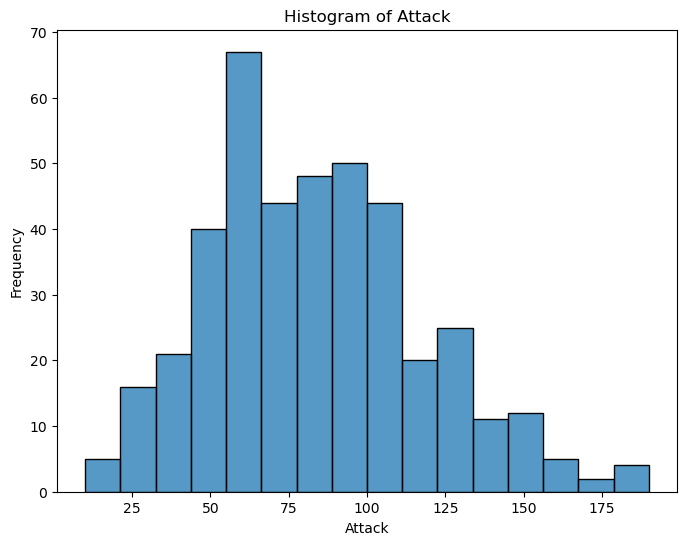

In [161]:
# Пример использования для гистограммы по колонке Attack
plot_histogram(df, 'Attack')

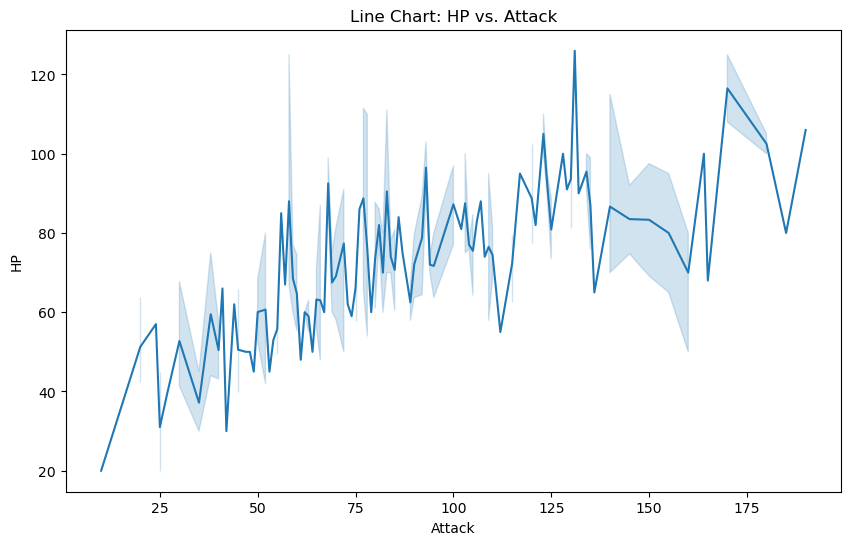

In [159]:
# Линейный график для колонок Defense и HP
plot_line_chart(df, 'Attack', 'HP')

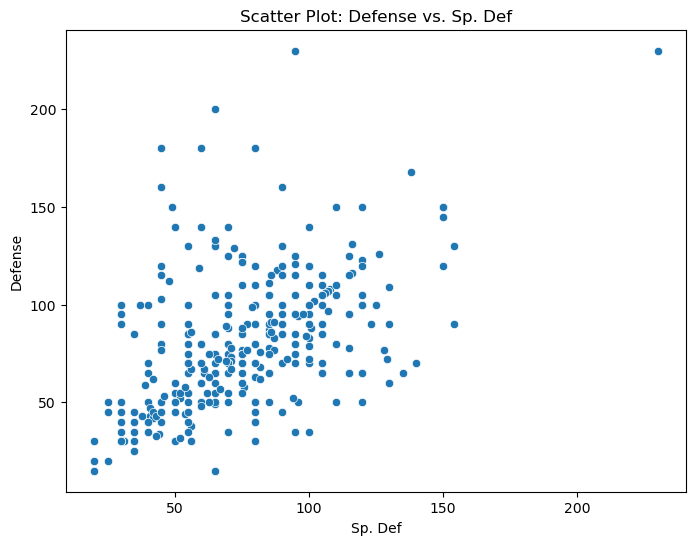

In [158]:
# Диаграмма рассеяния для колонок Sp. Def и Defense
plot_scatter_plot(df, 'Sp. Def', 'Defense')